In [1]:
from pathlib import Path

import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime as dt
from datetime import timedelta as td
from datetime import time

In [2]:
import sys

# append the path of the
# parent directory
sys.path.append('..')

In [3]:
from scripts import summarize_call_detection

In [4]:
# These are constants that we absolutely need to know before running any scripts

# Constant DATE is the date of our recovered data that we are extracting detections from
DATE = "20220815"
# Constant SD_CARD_NUM is the SD CARD # that had been deployed for that session
SD_CARD_NUM = "008"

path_to_records = Path(f"ubna_2022b.csv")
field_records = summarize_call_detection.get_field_records(path_to_records)
site_name = summarize_call_detection.get_site_name(field_records, DATE, SD_CARD_NUM)
print(f"Looking at data from {site_name}...")

Looking at data from Central Pond...


In [5]:
recover_folder = f"recover-{DATE}-{SD_CARD_NUM}-detect"
detection_dir = f"detections"
df = summarize_call_detection.generate_df(f"{detection_dir}/{recover_folder}")
df

,File Names,Date,Start Time (UTC),End Time (UTC),# of LF detections,# of HF detections
0,20220812_001017.WAV,2022-08-12,00:10:17,00:29:55,0.0,0.0
1,20220812_003000.WAV,2022-08-12,00:30:00,00:59:55,0.0,0.0
2,20220812_010000.WAV,2022-08-12,01:00:00,01:29:55,0.0,0.0
3,20220812_013000.WAV,2022-08-12,01:30:00,01:59:55,0.0,0.0
4,20220812_020000.WAV,2022-08-12,02:00:00,02:29:55,0.0,0.0
...,...,...,...,...,...,...
174,20220815_150000.WAV,2022-08-15,15:00:00,15:29:55,1.0,0.0
175,20220815_153000.WAV,2022-08-15,15:30:00,15:59:55,0.0,0.0
176,20220815_160000.WAV,2022-08-15,16:00:00,16:29:55,0.0,0.0
177,20220815_163000.WAV,2022-08-15,16:30:00,16:59:55,0.0,0.0


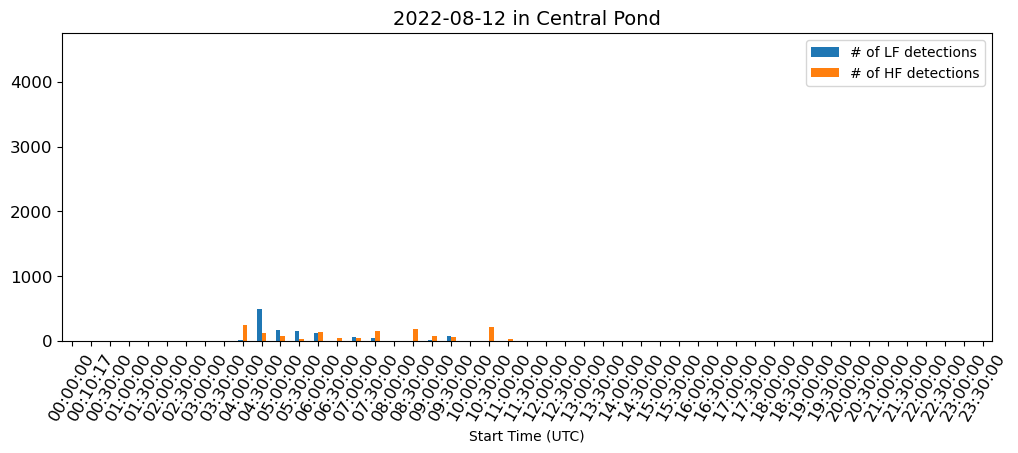

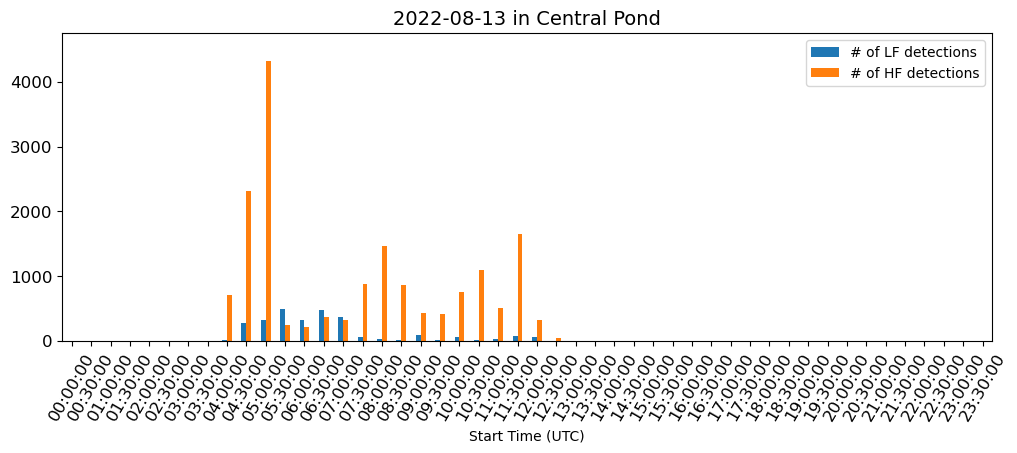

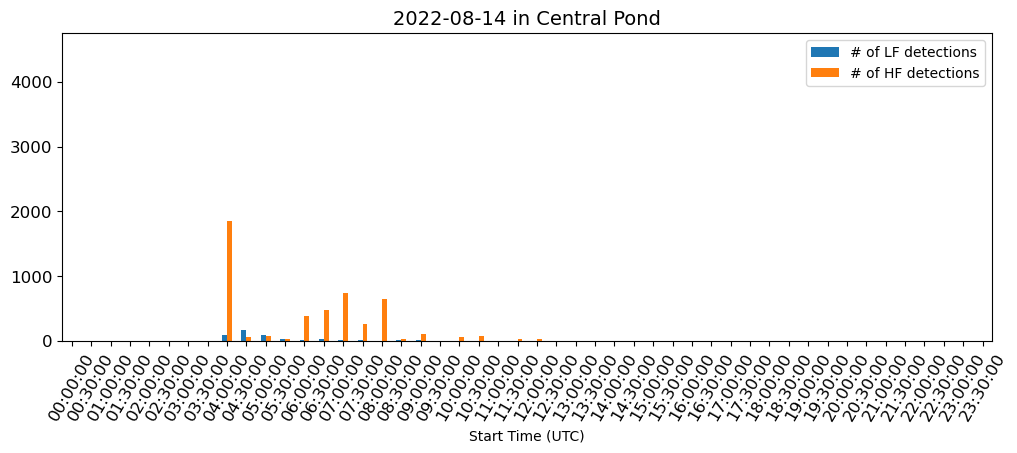

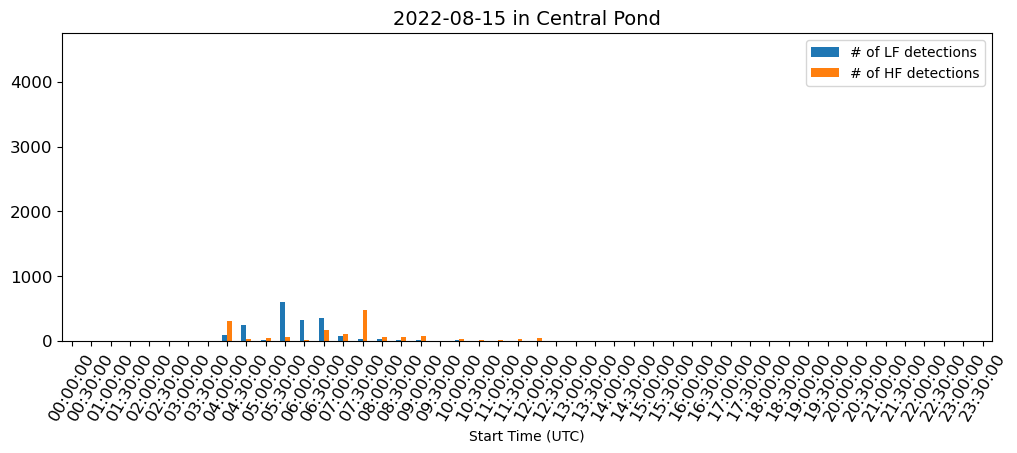

In [6]:
summarize_call_detection.plot_separate(df, site_name, recover_folder, save=True)

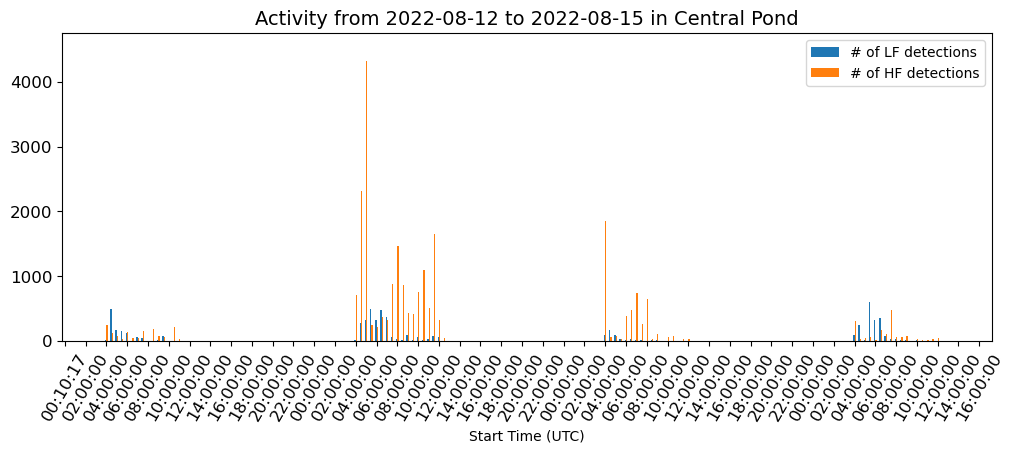

In [7]:
summarize_call_detection.plot_total(df, site_name)

In [8]:
df_all = summarize_call_detection.generate_all_df_from_site(field_records, site_name, detection_dir)

In [9]:
lf_activity_df = summarize_call_detection.generate_dtype_matrix_from_df(df_all, 'LF')
hf_activity_df = summarize_call_detection.generate_dtype_matrix_from_df(df_all, 'HF')

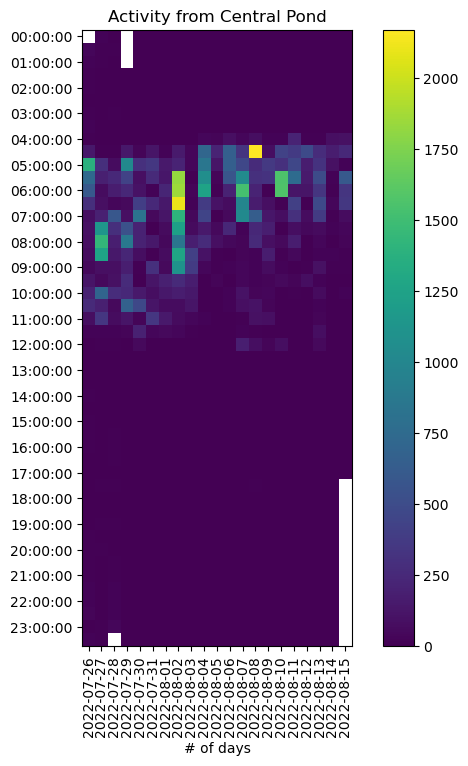

In [10]:
summarize_call_detection.plot_matrix(lf_activity_df, site_name, 'LF')

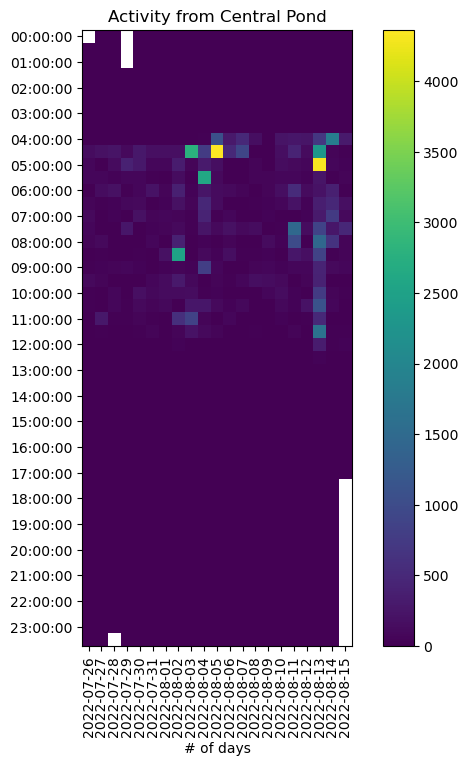

In [11]:
summarize_call_detection.plot_matrix(hf_activity_df, site_name, 'HF')